##  Step 2 : Plot and Select Mineral Resources

Machine learning algorithm requires data to train the model. In this notebook, we are going to select some mineral deposits which we are interested in. And then these chosen deposits will be used as input in Step 3 to retrieve more attributes from the trench sample points. After that, in Step 4, we can format the data so that they are ready to be fed into the machine learning models in Step 5.

Now let's select some interesting mineral deposits and prepare the data for the next step. The Step 3 takes a csv file as input, which should contain five columns. 

* index       -- unique number to identify the deposit
* lon         -- the longitude of the deposit
* lat         -- the latitude of the deposit
* age         -- how old the deposit is
* plate id    -- an ID for the tectonic plate in which the deposit resides, this ID is used in plate tectonic reconstruction

The ultimate goal of this step is to produce the csv file with the above five columns. There are many ways to get data and prepare the csv file. We are going to show you some examples below. After you have gone through the examples, you should have learnt how to create the csv file. And you are encouraged to come up with your own novel ways to find and process data, for example hack into KGB database, ect. Remember, only the final csv file matters. Focus on the five columns inside the csv file.

---

#### Example 1: Use ../data/CopperDeposits/XYBer14_t2_ANDES.shp data

This is the simplest example. 

We just load in data from a shape file and write out the five-column data to a csv file.

Run the script to create an example coregistration input file for XYBer14_t2_ANDES.shp dataset.

The coregistration input file can be used later in step 3: coregistration.

##### The implementation details are in create_coregistration_input_data_example.py.
If you would like to know more magic behind the scene, open [create_coregistration_input_data_example.py](create_coregistration_input_data_example.py)

In [1]:
import pandas as pd
from parameters import parameters as param
from create_coregistration_input_data_example import *

#get start time, end time and time step from parameters.py
start_time = param["time"]["start"]
end_time = param["time"]["end"]
time_step =  param["time"]["step"]

#first, we process the real deposits from XYBer14_t2_ANDES.shp
data = process_real_deposits(start_time, end_time, time_step)

#then, we copy the real deposits and replace the age with random number
#these deposits with random ages will be labeled as non-deposit later
random_data = generate_random_deposits(data, start_time, end_time)

#we also save the trench sample points for each time step
#they will be used as test dataset later
trench_data = generate_trench_points(start_time, end_time, time_step)

#concatenate all the data and fix the indices
all_data = data + random_data + trench_data
for i in range(len(all_data)): 
    all_data[i][0] = i #assign correct indices

deposit_len = len(data)
#save all the data into a csv file
save_data(all_data, f'coregistration_input_data_example_{deposit_len}.csv')

#open and display the final csv file
data = pd.read_csv(f"coregistration_input_data_example_{deposit_len}.csv") 
data.head()#let's print the first 5 rows

The data have been written into coregistration_input_data_example_155.csv successfully!


,index,lon,lat,age,plate_id
0,0,-66.28,-27.37,6,201
1,1,-69.37,-31.30,230,201
2,2,-69.75,-30.50,12,201
3,3,-66.65,-27.27,9,201
4,4,-66.61,-27.33,8,201


Now, let's plot a map to see the trench and copper deposits in Andes.

Since the deposits are all in Andes, draw the map with extent "-85, -30, -55, 15"(South America). The deposits are coloured by their ages.

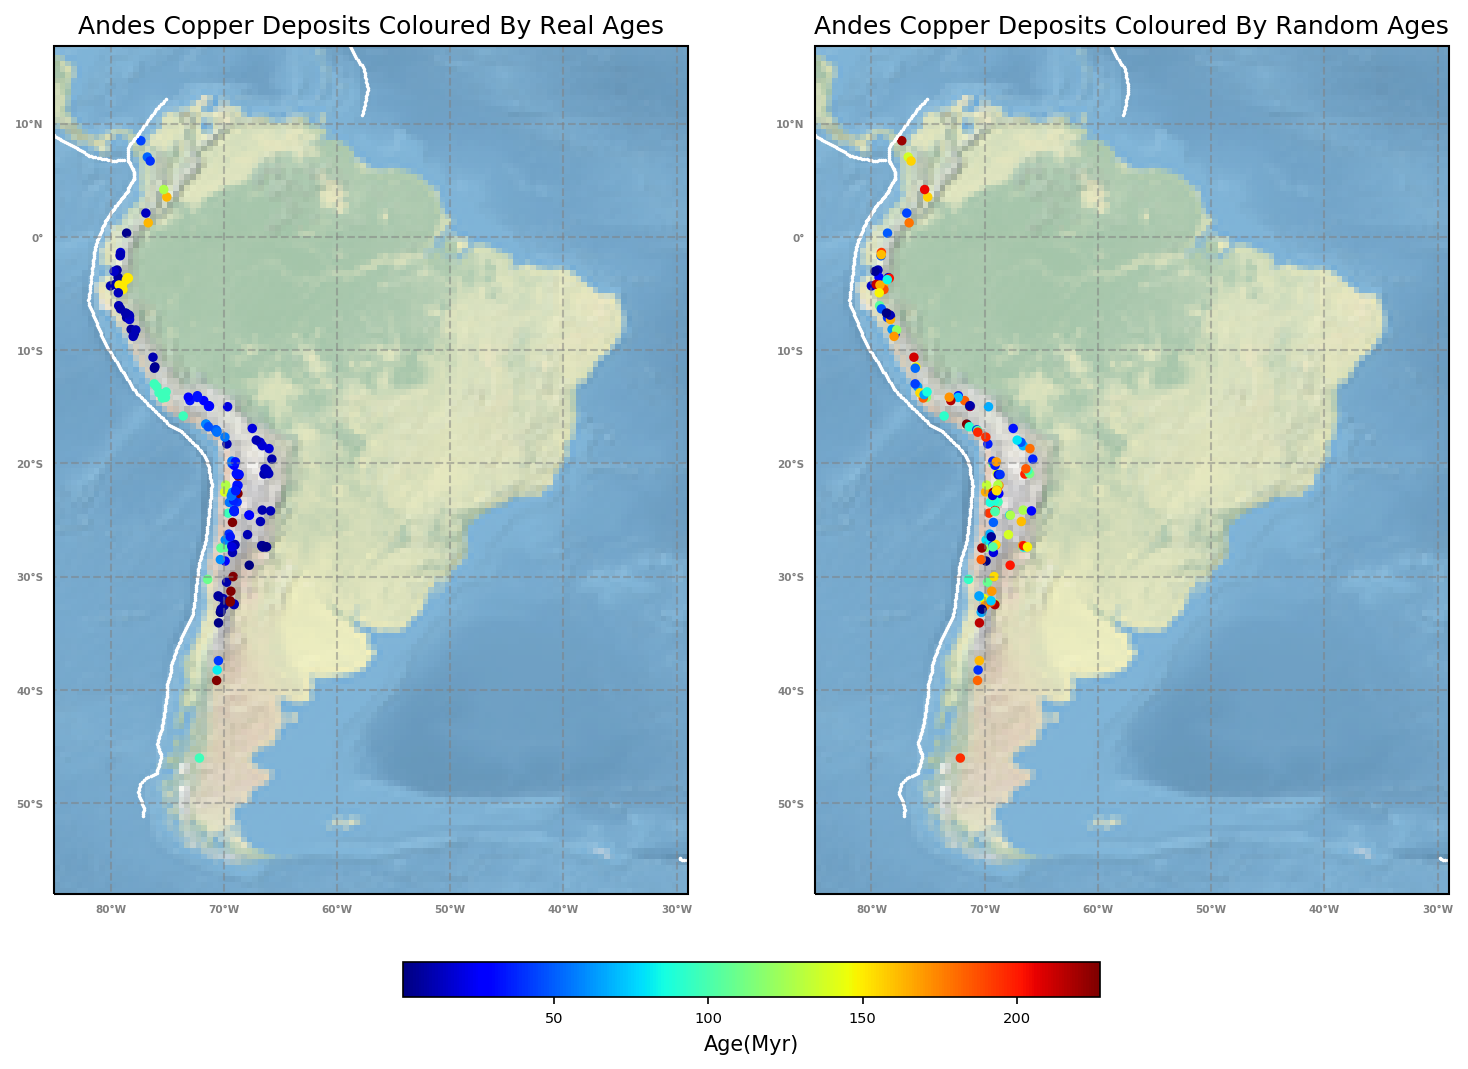

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def set_ax(ax):
    ax.stock_img()
    ax.set_extent([-85, -29, -55, 15])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -80, -70, -60,-50,-40,-30, 0, 180])
    gl.ylocator = mticker.FixedLocator([-90,-50,-40, -30, -20,-10, 0, 10, 20, 30, 40,50, 90])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}
    gl.ylabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}

trench_file = './convergence_data/subStats_0.00.csv'
trench_data= np.genfromtxt(trench_file)

data_1 = data[:155] # the first 155 rows are real deposits
data_2 = data[155:310] #the next 155 rows have random ages

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(12,12),dpi=150)
set_ax(ax1)
set_ax(ax2)

cb = ax1.scatter(data_1['lon'], data_1['lat'], 50, marker='.',c=data_1['age'],  cmap=plt.cm.jet)
cb = ax2.scatter(data_2['lon'], data_2['lat'], 50, marker='.',c=data_2['age'],  cmap=plt.cm.jet)
ax1.scatter(trench_data[:,0], trench_data[:,1], 2, marker='.', color='white')# draw the trench in white
ax2.scatter(trench_data[:,0], trench_data[:,1], 2, marker='.', color='white')# draw the trench in white
ax1.title.set_text('Andes Copper Deposits Coloured By Real Ages')
ax2.title.set_text('Andes Copper Deposits Coloured By Random Ages')
cbar = fig.colorbar(cb, shrink=0.5, ax=[ax1, ax2], orientation='horizontal', pad=0.05)
cbar.set_label('Age(Myr)',size=10)
cbar.ax.tick_params(labelsize=7)
plt.show()

#### Example 2: Extract Data From EarthChem Data

In this part, we are going to show you how to extract data from EarthChem database and draw the deposits on a map.

We will select deposits which are within a region(5 degrees) of any trench sample point. The data will also be filtered by mineral type.

#### Some mineral symbols and their meaning

* CU -- Copper
* CO2 -- Carbon dioxide
* ZN -- Zinc
* AU -- Gold
* GA -- Gallium
* CS -- Caesium
* LI -- Lithium
* AG -- Sliver

#### All the mineral symbols in EarthChem data
* SIO2,U234_U238,TIO2,AL2O3,FE2O3,TH230_TH232,FE2O3T,TH232_TH230,FEO,FEOT,MGO,RA228_RA226,CAO,NA2O,K2O,
* P2O5,MNO,U238_ACTIVITY,LOI,H2O_PLUS,TH230,H2O_MINUS,H2O,RA226,CR2O3,NIO,LA,CE,CACO3,PR,SM,EU,GD,TB,DY,
* HO,ER,TM,YB,U234_U238_ACTIVITY,LU,LI,BE,B,C,CO2,F,CL,K,CA,MG,SC,TI,V,FE,CR,MN,CO,NI,CU,ZN,GA,ZR,GER,SR,
* K40_AR36,BI,OS187_OS188,NB,TH232_U238,PB208_PB206,CD,PO210_TH230,U238_PB204,BA,AR40_AR36,W,AR37_AR39,AU,
* XE129_XE132,LU176_HF177,HG,OS186_OS188,PB206_PB208,TA,PB210_U238,SB,SR87_SR86,SE,PB207_PB204,PB206_PB204,
* PB208_PB204,SN,S,TH230_U238,ND143_ND144,U,RA226_TH230,I,P,Y,EPSILON_ND,MO,OS184_OS188,PD,RA226_TH228,TE,
* TH232_PB204,HF,OS187_OS186,CL36_CL,RA228_TH232,PB206_PB207,PB,INDIUM,H,PB210_RA226,AR38_AR36,AR40_AR39,D18O,
* AG,TH,U235_PB204,NE21_NE22,TL,NE20_NE22,AS,HF176_HF177,RB,AL,BE10_BE9,AR36_AR39,ND,CS,quartz

In [3]:
import requests, os
import numpy as np
import pandas as pd
import extract_earth_chem

earth_chem_file = 'EarthChem_all.csv'
#if EarthChem_all.csv does not exist, download it.
if not os.path.isfile(earth_chem_file):
    if os.path.isfile('/data/EarthChem_all.csv'):
        earth_chem_file = '/data/EarthChem_all.csv'
    else:
        print(f'downloading {earth_chem_file}')
        myfile = requests.get('https://www.earthbyte.org/webdav/ftp/earthbyte/EarthChem/EarthChem_all.csv')
        open(earth_chem_file, 'wb').write(myfile.content)


#select data from EarthChem dataset
#the result will be saved in "output file"
extract_earth_chem.main(
    earth_chem_file, #input file
    'EarthChem_CU', #output file
    'CU', #mineral symbol, see above list
    5 #region of interest (in degrees)
)

data=pd.read_csv('EarthChem_CU.csv')
data

loading data...


/home/mchin/anaconda3/envs/machine_learning/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (2,5,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


query data...
44160
saving file...


,LATITUDE,LONGITUDE,AGE,CU
0,48.141,-121.042,12.0000,70.0
1,48.149,-121.116,12.0000,30.0
2,48.151,-121.023,12.0000,15.0
3,19.260,-99.030,2.0000,15.0
4,19.380,-99.660,2.0000,39.0
...,...,...,...,...
44155,20.053,117.419,0.0102,31.0
44156,20.053,117.419,0.0107,35.0
44157,20.053,117.419,0.0135,30.0
44158,20.053,117.419,0.0138,33.0


Now, we have selected 44160 copper deposits from the EarthChem database.

Do you rememer we need five columns?

The EarthChem_CU.csv does not have "index" and "plate id" columns and it has a extra "CU" column.

The "index" column can be easily generated and the extra "CU" column can be dropped. However, the "plate id" column is a bit tricky. Let me show you how to deal with it in the next code cell.

In [4]:
import pygplates
#first, let's find plate id for those deposits
point_features = []
for index,row in data.iterrows():
    point = pygplates.PointOnSphere(float(row.LATITUDE),float(row.LONGITUDE))
    point_feature = pygplates.Feature()
    point_feature.set_geometry(point)
    point_feature.set_name(str(index))
    point_features.append(point_feature)

static_polygons = pygplates.FeatureCollection(
    '../data/Shapefiles/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2015_v1.shp')
rotation_model = pygplates.RotationModel('../data/Global_EarthByte_230-0Ma_GK07_AREPS.rot')

# partition features
points = pygplates.partition_into_plates(static_polygons, rotation_model, point_features)
plate_ids = [p.get_reconstruction_plate_id() for p in points]



In [5]:
indices = list(range(len(plate_ids)))
ages = np.round(data.AGE)
np.savetxt('EarthChem_CU_all.csv', np.c_[indices, data.LONGITUDE, data.LATITUDE, ages, plate_ids], 
           fmt='%d, %.4f, %.4f, %d, %d', header='index,lon,lat,age,plate_id',comments='')
data=pd.read_csv('EarthChem_CU_all.csv')
data

,index,lon,lat,age,plate_id
0,0,-121.042,48.141,12,173
1,1,-121.116,48.149,12,173
2,2,-121.023,48.151,12,173
3,3,-99.030,19.260,2,215
4,4,-99.660,19.380,2,215
...,...,...,...,...,...
44155,44155,117.419,20.053,0,612
44156,44156,117.419,20.053,0,612
44157,44157,117.419,20.053,0,612
44158,44158,117.419,20.053,0,612


Now, the data in EarthChem_CU_all.csv have all the five columns we need. 

Next, let's plot the data in a map.

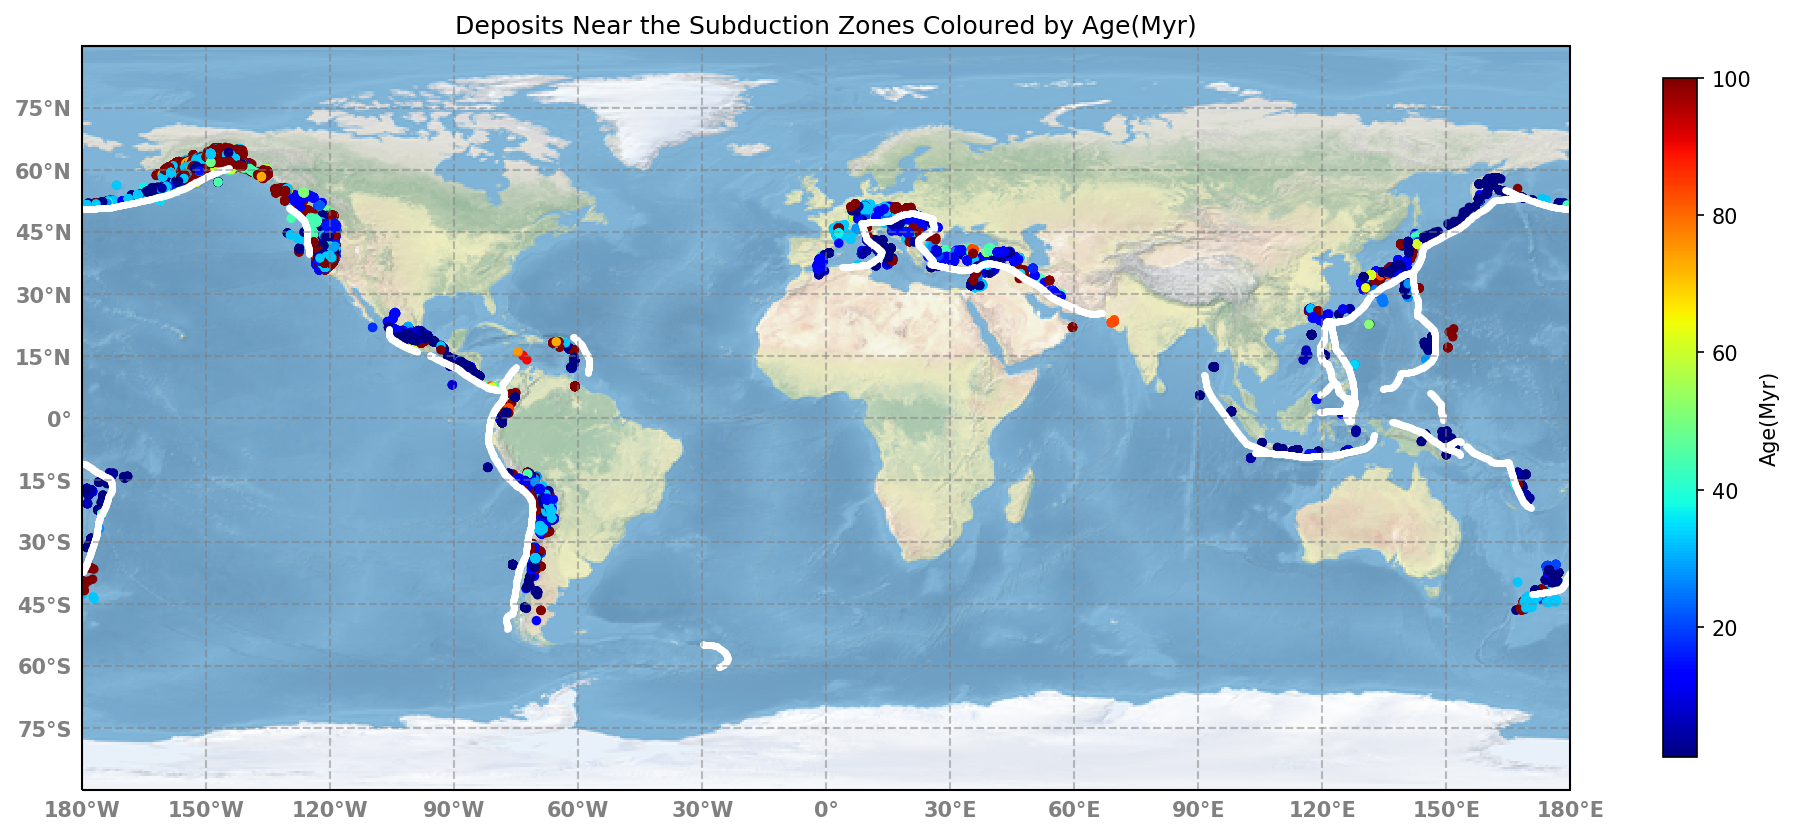

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

trench_file = './convergence_data/subStats_0.00.csv'
if os.path.isfile(trench_file):
    trench_data= np.genfromtxt(trench_file)
else:
    raise Exception(f'\nERROR: unable to open file {trench_file}. \nRun Step 1 Generate Subduction Convergence Kinematics Statistics first!')
    
#plot the data    
fig = plt.figure(figsize=(16,12),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mticker.FixedLocator([-90, -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}

ax.stock_img()
ax.set_extent([-180, 180, -90, 90])
cb = ax.scatter(data['lon'], data['lat'], 50, marker='.',c=data['age'], vmin=1, vmax=100, cmap=plt.cm.jet)
ax.scatter(trench_data[:,0], trench_data[:,1], 20, marker='.', color='white')
plt.title('Deposits Near the Subduction Zones Coloured by Age(Myr)')
fig.colorbar(cb, shrink=0.5, label='Age(Myr)')
plt.show()

Let's take a closer look at South America.

Data South America shape: (1762, 5)


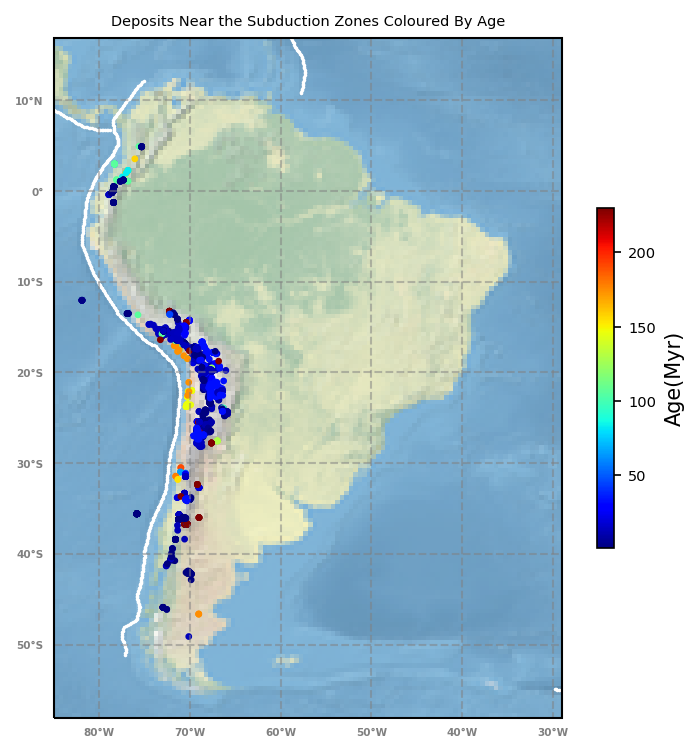

In [7]:
#select data within bounding box [-85, -30, -55, 15]
data_south_america = data[data['lon']>-85]
data_south_america = data_south_america[data_south_america['lon']<-30]
data_south_america = data_south_america[data_south_america['lat']>-55]
data_south_america = data_south_america[data_south_america['lat']<5]
print(f'Data South America shape: {data_south_america.shape}')

#plot the map
fig = plt.figure(figsize=(6,6),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-85, -29, -55, 15])

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -80, -70, -60,-50,-40,-30, 0, 180])
gl.ylocator = mticker.FixedLocator([-90,-50,-40, -30, -20,-10, 0, 10, 20, 30, 40,50, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}
gl.ylabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}

cb = ax.scatter(data_south_america['lon'], data_south_america['lat'], 20, marker='.',
                c=data_south_america['age'], vmin=1, vmax=230, cmap=plt.cm.jet)
ax.scatter(trench_data[:,0], trench_data[:,1], 2, marker='.', color='white')# draw the trench in white
plt.title('Deposits Near the Subduction Zones Coloured By Age',fontsize=7)
cbar = fig.colorbar(cb, shrink=0.5)
cbar.set_label('Age(Myr)',size=10)
cbar.ax.tick_params(labelsize=7)
plt.show()

Everything looks good. Now, let's append the deposits with random ages and trench points

In [8]:
data=data_south_america.values.tolist()
#then, we copy the real deposits and replace the age with random number
#these deposits with random ages will be labeled as non-deposit later
random_data = generate_random_deposits(data, start_time, end_time)

#we also save the trench sample points for each time step
#they will be used as test dataset later
trench_data = generate_trench_points(start_time, end_time, time_step)

#concatenate all the data and fix the indices
all_data = data + random_data + trench_data
for i in range(len(all_data)): 
    all_data[i][0] = i #assign correct indices

deposit_len = len(data)
#save all the data into a csv file
save_data(all_data, f'EarthChem_CU_south_america_{deposit_len}.csv')
data=pd.read_csv(f'EarthChem_CU_south_america_{deposit_len}.csv')
data

The data have been written into EarthChem_CU_south_america_1762.csv successfully!


,index,lon,lat,age,plate_id
0,0,-76.08,3.56,158,201
1,1,-76.83,2.29,158,201
2,2,-76.83,2.29,158,201
3,3,-76.83,2.29,158,201
4,4,-76.83,2.29,158,201
...,...,...,...,...,...
95749,95749,-71.12,-22.54,229,201
95750,95750,-71.10,-22.37,229,201
95751,95751,-71.09,-22.19,229,201
95752,95752,-71.08,-21.84,229,201


#### Example 3: PorCuEX2008.csv

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd
import Utils

#read in data
data = pd.read_csv("../data/PorCuEX2008.csv")
trench_data= np.genfromtxt('./convergence_data/subStats_0.00.csv')
print(f'Data shape: {data.shape}')
print('The first 5 rows in the data:')
display(data.head())

print('All the columns in the data:')
print(data.columns)

#select deposits within 5 degrees of trench
indices = Utils.select_points_in_region(data['LongitudeDecimal'], data['LatitudeDecimal'], 
                              trench_data[:,0], trench_data[:,1], 5)#5 degrees
data_near_trench = data[indices]
print(f'Data near trench shape: {data_near_trench.shape}')

#select data within bounding box [-85, -30, -55, 15]
data_south_america = data_near_trench[data_near_trench['LongitudeDecimal']>-85]
data_south_america = data_south_america[data_near_trench['LongitudeDecimal']<-30]
data_south_america = data_south_america[data_near_trench['LatitudeDecimal']>-55]
data_south_america = data_south_america[data_near_trench['LatitudeDecimal']<5]
print(f'Data South America shape: {data_south_america.shape}\n')

#the data_big and data_small do not always have the same length
#for example, when there are more than half of the values are zeros, 
#they should all be considered small values
def divide_data(data, column_name):
    tmp = data.fillna(value={column_name:0})
    data_sorted = tmp.sort_values(by=column_name, ascending=False)
    #print(data_sorted[column_name])
    middle_value = data_sorted[column_name].values.tolist()[int(data_sorted.shape[0]/2)]
    #print(middle_value)
    data_big = data_sorted[data_sorted[column_name]>middle_value]
    data_small = data_sorted[data_sorted[column_name]<=middle_value]
    #print(f'big {column_name}: \n', data_big[column_name])
    #print(f'small {column_name}: \n', data_small[column_name])
    return data_big, data_small

#divide data by Tonnage
big_tonnage, small_tonnage = divide_data(data_near_trench, 'Tonnage')

#We can do the same to 'Copper grade', 'Molybdenum grade', 'Gold grade', 'Silver grade'
big_copper_percent, small_copper_percent = divide_data(data_near_trench, 'Copper grade')
big_molybdenum_percent, small_molybdenum_percent = divide_data(data_near_trench, 'Molybdenum grade')
big_gold_percent, small_gold_percent = divide_data(data_near_trench, 'Gold grade')
big_silver_percent, small_siler_percent = divide_data(data_near_trench, 'Silver grade')


Data shape: (690, 43)
The first 5 rows in the data:


,NameDeposit,Includes,OtherNames,Country,CountryCode,StateProvince,LatitudeDecimal,LongitudeDecimal,AgeMY,Deposit Age,...,OreBAxis,OreArea,AlterAAxis,AlterBAxis,AlterArea,SulfideAAxis,SulfideBAxis,SulfideArea,Comments,References
0,Agua Rica,NaN,Mi Vida,Argentina,AGTN,Catamarca,-27.370833,-66.280000,5.5,6–5,...,0.0,0.00,4.4,3.80,13.1,0.0,0.0,5.7,0.2% Cu cut-off grade. Exposed. Superposition ...,"Bargmann, C.J., 2000, Agua Rica prospect, Cata..."
1,Alcaparrosa,NaN,NaN,Argentina,AGTN,San Juan,-31.300000,-69.366667,267.0,267,...,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,NaN,"Sillitoe, R.H., 1977, Permo-Carboniferous, upp..."
2,Arroyo Chita,NaN,Chita,Argentina,AGTN,San Juan,-30.500000,-69.750000,12.0,12,...,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,NaN,"Sillitoe, R.H., 1977, Permo-Carboniferous, upp..."
3,Bajo de Agua Tapado,NaN,NaN,Argentina,AGTN,Catamarca,-27.266667,-66.650000,8.5,11–6,...,0.0,0.00,5.3,1.50,6.2,1.3,1.1,1.1,"Thin veins ≤2.2 g/t Au, 174 g/t Ag. Exposed. F...","Alderete, M.C., 1999, Bajo de Agua Tapada, Cat..."
4,Bajo de la Alumbrera,NaN,NaN,Argentina,AGTN,Catamarca,-27.329722,-66.608889,7.5,8.02±0.14 to 6.75±0.09,...,0.6,0.52,2.5,1.75,3.4,0.0,0.0,0.0,1999 resources: 767 Mt at 0.51% Cu and 0.64 g/...,"Angera, J.A., 1999, Mina Bajo de la Alumbrera,..."


All the columns in the data:
Index(['NameDeposit', 'Includes', 'OtherNames', 'Country', 'CountryCode',
       'StateProvince', 'LatitudeDecimal', 'LongitudeDecimal', 'AgeMY',
       'Deposit Age', 'Tonnage', 'Copper grade', 'Molybdenum grade',
       'Gold grade', 'Silver grade', 'Subtype', 'EmpacementDepthkm',
       'Assoc Deposits less 10km', 'Assoc Deposits less 5km', 'DepositID',
       'LatitudeDegrees', 'LatitudeMinutes', 'LatitudeSeconds',
       'LongitudeDegrees', 'LongitudeMinutes', 'LongitudeSeconds', 'Minerals',
       'RocksInDeposit', 'RocksOnMap', 'RocksOnMapInDeposit', 'DiscoveryDate',
       'StartupDate', 'OreAAxis', 'OreBAxis', 'OreArea', 'AlterAAxis',
       'AlterBAxis', 'AlterArea', 'SulfideAAxis', 'SulfideBAxis',
       'SulfideArea', 'Comments', 'References'],
      dtype='object')
Data near trench shape: (394, 43)
Data South America shape: (135, 43)



/home/mchin/anaconda3/envs/machine_learning/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/mchin/anaconda3/envs/machine_learning/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/mchin/anaconda3/envs/machine_learning/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


##### Plot the data in a global map

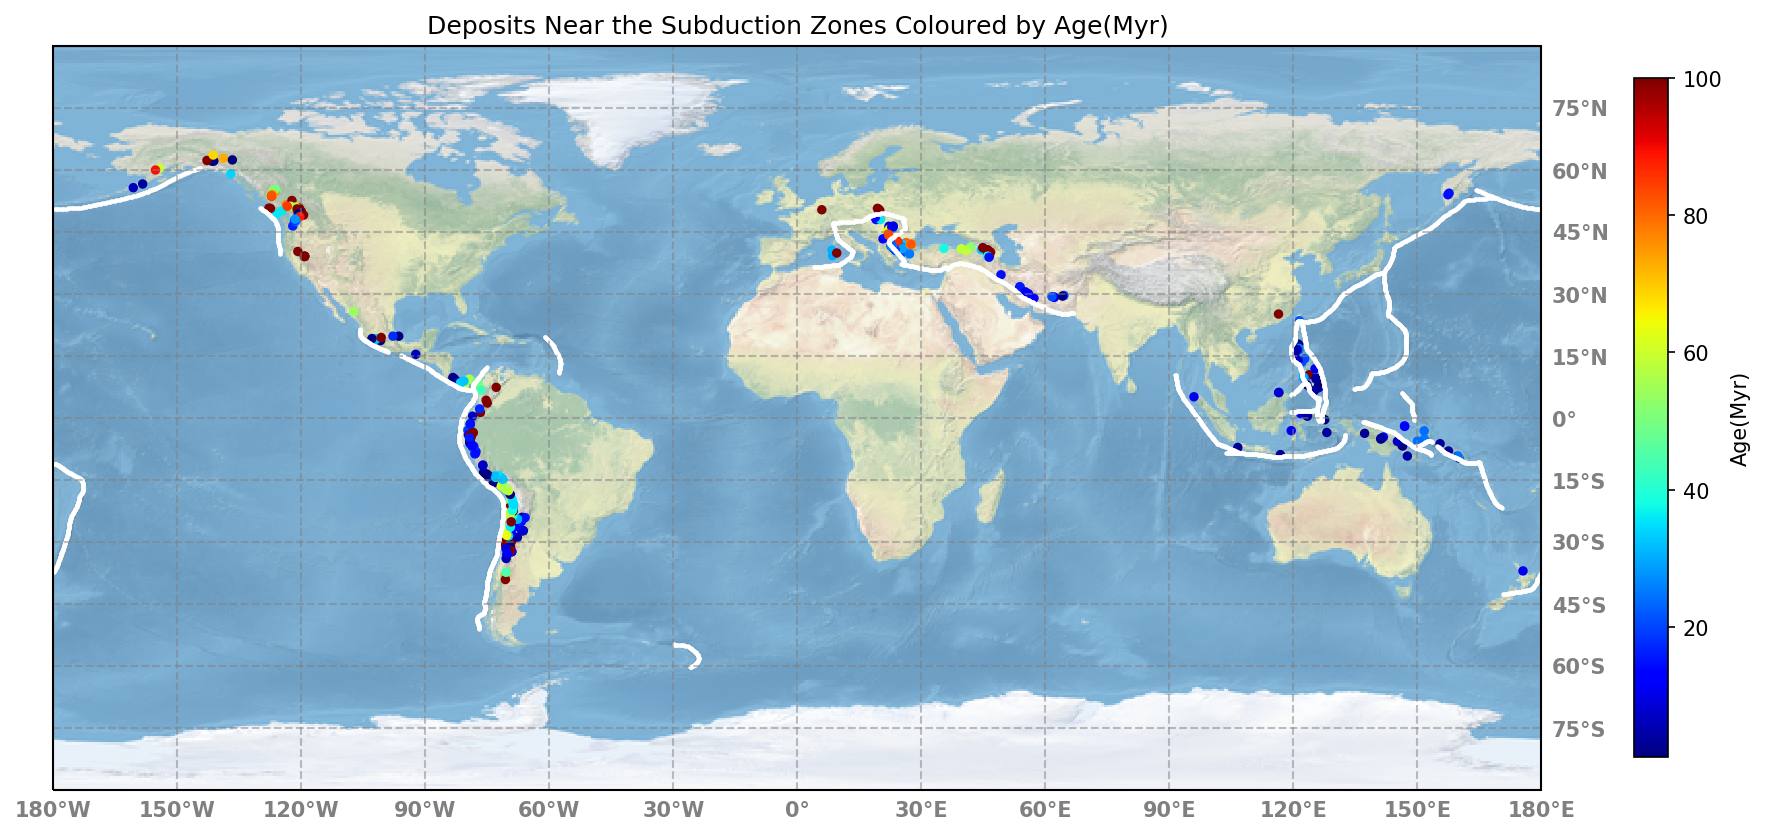

In [10]:
#*******************************************

#LOOK HERE!!
#you may choose the data to plot
#only keep the one line which you want uncommented

#plot_data = data
plot_data = data_near_trench
#plot_data = data_south_america
#plot_data = big_tonnage
#plot_data = small_tonnage
#plot_data = big_copper_percent 
#plot_data = small_copper_percent
#plot_data = big_molybdenum_percent
#plot_data = small_molybdenum_percent
#plot_data = big_gold_percent
#plot_data = small_gold_percent
#plot_data = big_silver_percent
#plot_data = small_siler_percent 
#*******************************************


#plot the map
fig = plt.figure(figsize=(16,12),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mticker.FixedLocator([-90, -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}

ax.stock_img()
ax.set_extent([-180, 180, -90, 90])
#ax.set_extent([-85, -29, -55, 15])
cb = ax.scatter(plot_data['LongitudeDecimal'], plot_data['LatitudeDecimal'], 50, marker='.',c=plot_data['AgeMY'], 
                vmin=1, vmax=100, cmap=plt.cm.jet)
ax.scatter(trench_data[:,0], trench_data[:,1], 5, marker='.', color='white')
plt.title('Deposits Near the Subduction Zones Coloured by Age(Myr)')
fig.colorbar(cb, shrink=0.5, label='Age(Myr)')
plt.show()

##### Plot a regional map

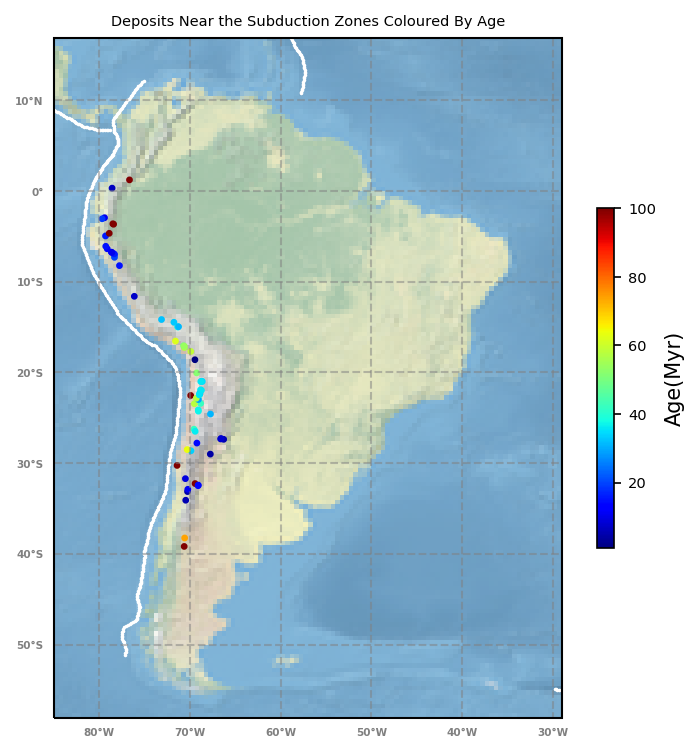

In [11]:
#divide data by Tonnage
big_tonnage, small_tonnage = divide_data(data_south_america, 'Tonnage')

#We can do the same to 'Copper grade', 'Molybdenum grade', 'Gold grade', 'Silver grade'
big_copper_percent, small_copper_percent = divide_data(data_south_america, 'Copper grade')
big_molybdenum_percent, small_molybdenum_percent = divide_data(data_south_america, 'Molybdenum grade')
big_gold_percent, small_gold_percent = divide_data(data_south_america, 'Gold grade')
big_silver_percent, small_siler_percent = divide_data(data_south_america, 'Silver grade')

#*******************************************

#LOOK HERE!!
#you may choose the data to plot
#only keep the one line which you want uncommented

#plot_data = data_south_america
plot_data = big_tonnage
#plot_data = small_tonnage
#plot_data = big_copper_percent 
#plot_data = small_copper_percent
#plot_data = big_molybdenum_percent
#plot_data = small_molybdenum_percent
#plot_data = big_gold_percent
#plot_data = small_gold_percent
#plot_data = big_silver_percent
#plot_data = small_siler_percent 
#******************************************

#plot the map
fig = plt.figure(figsize=(6,6),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-85, -29, -55, 15])
#ax.set_extent([-180, 180, -90, 90])
data=data[:155]

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -80, -70, -60,-50,-40,-30, 0, 180])
gl.ylocator = mticker.FixedLocator([-90,-50,-40, -30, -20,-10, 0, 10, 20, 30, 40,50, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}
gl.ylabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}

cb = ax.scatter(plot_data['LongitudeDecimal'], plot_data['LatitudeDecimal'], 20, marker='.',
                c=plot_data['AgeMY'], vmin=1, vmax=100, cmap=plt.cm.jet)
ax.scatter(trench_data[:,0], trench_data[:,1], 2, marker='.', color='white')# draw the trench in white
plt.title('Deposits Near the Subduction Zones Coloured By Age',fontsize=7)
cbar = fig.colorbar(cb, shrink=0.5)
cbar.set_label('Age(Myr)',size=10)
cbar.ax.tick_params(labelsize=7)
plt.show()

Add random age deposits and trench points. The PorCuEX2008_south_america.csv is ready to be used in Step 3.

In [12]:
import pygplates
#first, let's find plate id for those deposits
point_features = []
for index,row in data_south_america.iterrows():
    point = pygplates.PointOnSphere(float(row.LatitudeDecimal),float(row.LongitudeDecimal))
    point_feature = pygplates.Feature()
    point_feature.set_geometry(point)
    point_feature.set_name(str(index))
    point_features.append(point_feature)

static_polygons = pygplates.FeatureCollection(
    '../data/Shapefiles/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2015_v1.shp')
rotation_model = pygplates.RotationModel('../data/Global_EarthByte_230-0Ma_GK07_AREPS.rot')

# partition features
points = pygplates.partition_into_plates(static_polygons, rotation_model, point_features)
plate_ids = [p.get_reconstruction_plate_id() for p in points]

ages = np.round(data_south_america.AgeMY)
indices = list(range(len(ages)))

data=np.c_[indices,data_south_america.LongitudeDecimal,data_south_america.LatitudeDecimal, ages, plate_ids]
data=data[~np.isnan(data).any(axis=1)].tolist()
#then, we copy the real deposits and replace the age with random number
#these deposits with random ages will be labeled as non-deposit later
random_data = generate_random_deposits(data, start_time, end_time)

#we also save the trench sample points for each time step
#they will be used as test dataset later
trench_data = generate_trench_points(start_time, end_time, time_step)

#concatenate all the data and fix the indices
all_data = data + random_data + trench_data
for i in range(len(all_data)): 
    all_data[i][0] = i #assign correct indices

deposit_len = len(data)
#save all the data into a csv file
save_data(all_data, f'PorCuEX2008_south_america_{deposit_len}.csv')
data=pd.read_csv(f'PorCuEX2008_south_america_{deposit_len}.csv')
data

The data have been written into PorCuEX2008_south_america_122.csv successfully!


,index,lon,lat,age,plate_id
0,0,-66.28,-27.37,6,202
1,1,-69.37,-31.30,267,202
2,2,-69.75,-30.50,12,202
3,3,-66.65,-27.27,8,202
4,4,-66.61,-27.33,8,202
...,...,...,...,...,...
92469,92469,-71.12,-22.54,229,201
92470,92470,-71.10,-22.37,229,201
92471,92471,-71.09,-22.19,229,201
92472,92472,-71.08,-21.84,229,201


#### This is the end of step 2 and now open the step 3 notebook
[3_Coregistration.ipynb](3_Coregistration.ipynb)